# Bone suppression(U-Net)

## 前準備
### 主要パッケージのインポート

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from logging import basicConfig, getLogger, INFO
basicConfig(level=INFO, format='%(asctime)s %(levelname)s :%(message)s')
logger = getLogger(__name__)

### データディレクトリの指定

In [2]:
DATA_ROOT = pathlib.Path('Data/Images/chest_xray')
INPUT_IMAGE_DIR = 'bone_enhancement'
TRUTH_IMAGE_DIR = 'bone_suppression'
CLASS_LABELS = ('lung')
IMAGE_EXT = '.png'

### 画像ファイルを基にpd.DataFrameを作成する

In [3]:
def create_dataset_df(data_root, input_dir, truth_dir, image_ext):
    dfs = []
    root = pathlib.Path(data_root)
    image_filenames = (root / pathlib.Path(input_dir)).glob('*' + image_ext)
    df = pd.DataFrame(image_filenames, columns=['input_path'])
    df['truth_path'] = df['input_path'].map(
        lambda p: root / pathlib.Path(truth_dir) / p.name)
    return df


df_dataset = create_dataset_df(DATA_ROOT, INPUT_IMAGE_DIR, TRUTH_IMAGE_DIR,
                               IMAGE_EXT)
display(df_dataset.head())

,input_path,truth_path
0,Data\Images\chest_xray\bone_enhancement\000.png,Data\Images\chest_xray\bone_suppression\000.png
1,Data\Images\chest_xray\bone_enhancement\001.png,Data\Images\chest_xray\bone_suppression\001.png
2,Data\Images\chest_xray\bone_enhancement\002.png,Data\Images\chest_xray\bone_suppression\002.png
3,Data\Images\chest_xray\bone_enhancement\003.png,Data\Images\chest_xray\bone_suppression\003.png
4,Data\Images\chest_xray\bone_enhancement\004.png,Data\Images\chest_xray\bone_suppression\004.png


### 画像を表示

<Figure size 720x360 with 0 Axes>

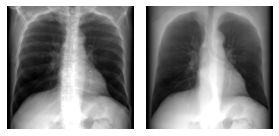

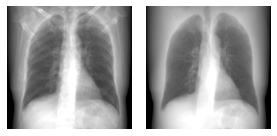

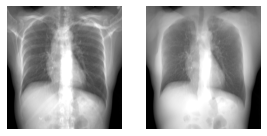

In [4]:
N_SAMPLES = 3
plt.figure(figsize=(10, 5))
for i, sample in enumerate(df_dataset.sample(n=N_SAMPLES).itertuples()):
    image = Image.open(sample.input_path)
    truth = Image.open(sample.truth_path)
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(truth, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### Data augmentation

In [5]:
import functools
import tut_utils
INPUT_SHAPE = [1, 256, 256]
IMG_SHAPE = INPUT_SHAPE


def load_img(filepath):
    img = Image.open(filepath)
    img = img.resize(IMG_SHAPE[1:])
    return np.atleast_3d(img)


load_img2img_dataset = functools.partial(tut_utils.load_img2img_dataset,
                                         input_column='input_path',
                                         target_column='truth_path')

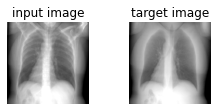

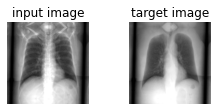

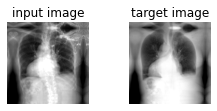

In [6]:
import albumentations as A
from tut_utils import AugmentedDataset
import torch

album_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=.1, contrast_limit=.1, p=.5),
    A.HorizontalFlip(p=.25),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=.2, rotate_limit=10, p=.8)
],
                            additional_targets={'image0': 'image'})


def random_transform(x, y):
    x = (x / 255).astype(np.float32)
    y = (y / 255).astype(np.float32)
    tfed = album_transform(image=x, image0=y)
    x, y = tfed['image'], tfed['image0']
    x, y = x.transpose(2, 0, 1), y.transpose(2, 0, 1)
    return x.astype(np.float32), y.astype(np.float32)


N_TEST = 3


def test_augmentation(df_dataset):
    df_train = df_dataset.iloc[:N_TEST]
    train_data, train_labels = load_img2img_dataset(df_train, load_img)
    dataset = AugmentedDataset(train_data, train_labels, random_transform)
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=0)
    for i, data in enumerate(loader):
        plt.figure(figsize=(4, 1.5))
        plt.subplot(1, 2, 1)
        plt.imshow(data[0].squeeze().numpy(), cmap='gray')
        plt.title('input image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(data[1].squeeze().numpy(), cmap='gray')
        plt.title('target image')
        plt.axis('off')
        plt.show()


test_augmentation(df_dataset)

## モデル作成
U-Netを用いる

In [7]:
OUTPUT_CHANNELS = 1
UNET_DEPTH = 6
IN_CHS = 1
OUT_CHS = 1
INI_CHS = 16
from tut_models import UNet
from torchsummary import summary
summary(UNet(IN_CHS, OUT_CHS, UNET_DEPTH, ini_chs=INI_CHS),
        INPUT_SHAPE,
        verbose=0,
        device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Encoder: 2-1                      [-1, 32, 256, 256]        --
|    |    └─Sequential: 3-1              [-1, 32, 256, 256]        4,896
├─ModuleList: 1                          []                        --
|    └─MaxPool2d: 2-2                    [-1, 32, 128, 128]        --
├─ModuleList: 1                          []                        --
|    └─Encoder: 2-3                      [-1, 64, 128, 128]        --
|    |    └─Sequential: 3-2              [-1, 64, 128, 128]        27,936
├─ModuleList: 1                          []                        --
|    └─MaxPool2d: 2-4                    [-1, 64, 64, 64]          --
├─ModuleList: 1                          []                        --
|    └─Encoder: 2-5                      [-1, 128, 64, 64]         --
|    |    └─Sequential: 3-3              [-1, 128, 64, 64]         111,168
├─M

### Lit model
誤差関数は平均二乗誤差

In [8]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl


class LitUNet(pl.LightningModule):
    def __init__(self, in_chs, out_chs, depth):
        super().__init__()
        self.model = UNet(in_chs, out_chs, depth, ini_chs=INI_CHS)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
        return {
            'optimizer': optimizer,
            'scheduler': scheduler,
            'monitor': 'train_loss'
        }

## 学習
### ホールドアウト

In [9]:
from sklearn.model_selection import KFold
N_SPLITS = 5
SEED = 0
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
train_index, test_index = next(kfold.split(df_dataset['input_path']))

df_train = df_dataset.iloc[train_index]
df_test = df_dataset.iloc[test_index]

### Fit

GPU available: True, used: True
2021-03-31 14:19:40,703 INFO :GPU available: True, used: True
TPU available: None, using: 0 TPU cores
2021-03-31 14:19:40,705 INFO :TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-03-31 14:19:40,706 INFO :LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 34.6 M
-------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params
2021-03-31 14:19:41,940 INFO :
  | Name  | Type | Params
-------------------------------
0 | model | UNet | 34.6 M
-------------------------------
34.6 M    Trainable params
0         Non-trainable params
34.6 M    Total params


Training: 0it [00:00, ?it/s]

2021-03-31 14:21:28,869 INFO :Finish training


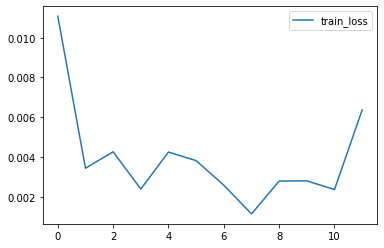

In [10]:
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import CSVLogger

NUM_WORKERS = 0 if os.name == 'nt' else 2
EPOCHS = 32
PATIENCE = 4
BATCH_SIZE = 4

model = LitUNet(IN_CHS, OUT_CHS, UNET_DEPTH)
train_data, train_labels = load_img2img_dataset(df_train, load_img)
dataset = AugmentedDataset(train_data, train_labels, random_transform)
trainloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          pin_memory=True,
                                          num_workers=NUM_WORKERS)

early_stop_callback = EarlyStopping(monitor='train_loss',
                                    patience=PATIENCE,
                                    verbose=False,
                                    mode='min')
csv_logger = CSVLogger('train_logs', name='img2img_unet')
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else 0,
                     max_epochs=EPOCHS,
                     logger=csv_logger,
                     log_every_n_steps=len(trainloader),
                     callbacks=[early_stop_callback])

trainer.fit(model, trainloader)
logger.info('Finish training')
df_logs = pd.read_csv(csv_logger.experiment.metrics_file_path)
df_logs.plot(y='train_loss')
plt.show()

## 評価
目視で評価する

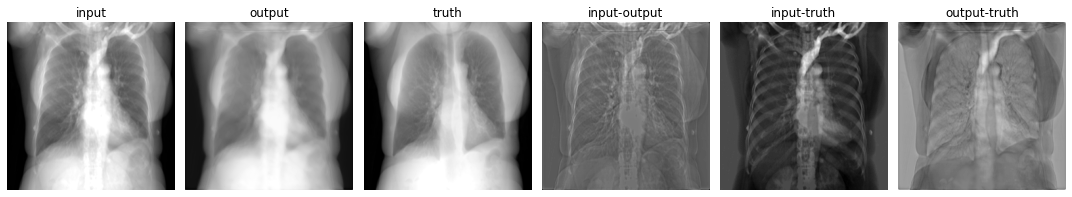

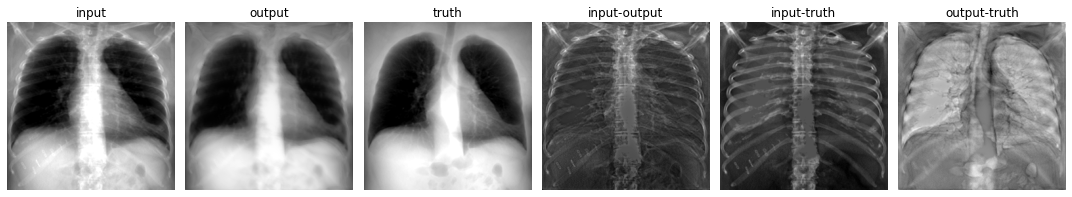

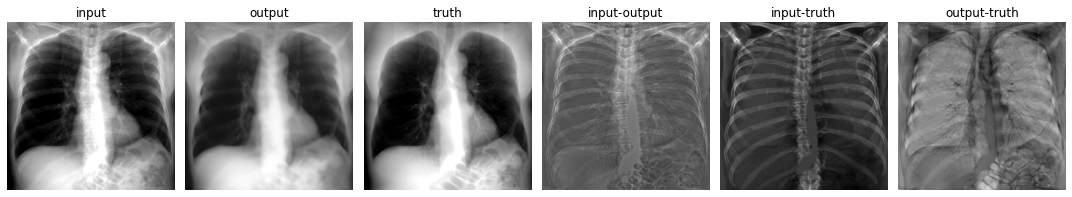

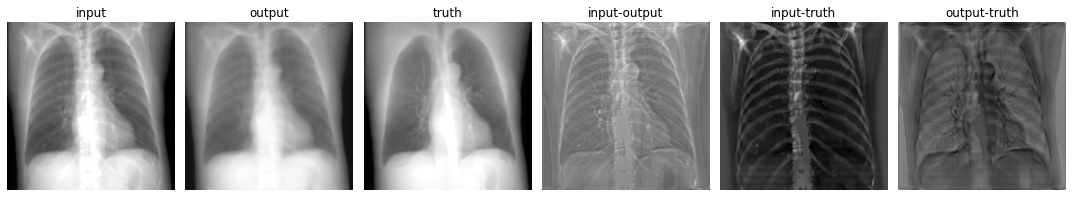

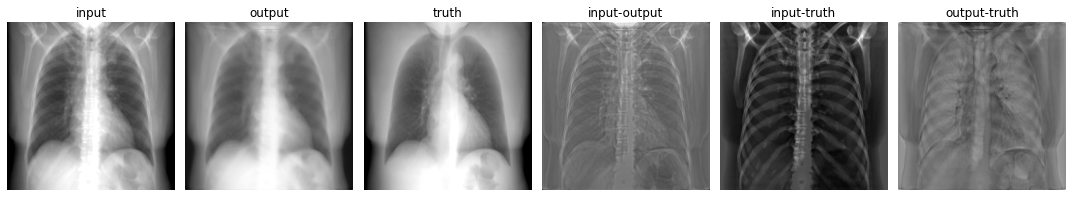

In [11]:
def show_images_in_a_row(images, titles, figsize=(15, 5)):
    assert len(images) == len(titles), 'Invalid size of arguments'
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


model.eval()
model.freeze()

scores = []
for i, index in enumerate(test_index):
    image = load_img(df_dataset.iloc[index].input_path)
    truth = load_img(df_dataset.iloc[index].truth_path)
    truth = np.array(truth) / 255
    truth = truth.squeeze()

    image = np.atleast_3d(image)
    image = np.array(image) / 255
    image = image.transpose(2, 0, 1)
    pred = model(torch.FloatTensor(image[np.newaxis])).squeeze().cpu().numpy()
    image = image.squeeze()
    if i < 5:
        show_images_in_a_row(*zip((image, 'input'), (pred, 'output'), (
            truth, 'truth'), (image - pred, 'input-output'), (
                image - truth, 'input-truth'), (pred - truth, 'output-truth')))
    else:
        break

## 保存
UNetを保存する

In [12]:
torch.save(model.model.state_dict(), 'unet_generator.ckpt')